# Initial study

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study used the following population from PPMI:
<img src="../data/table.png"/>

Note: this notebook can be shared publicly. It is implemented to not leak any PPMI patient information or id.

# Data loading and preparation

## Metadata download

In [1]:
import os
import ppmi_downloader

data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
required_files = ['Age_at_visit.csv', 'Demographics.csv', 'MDS_UPDRS_Part_III.csv']
missing_files = [x for x in required_files if not os.path.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader('mohanadarafework@gmail.com', 'MohanadKhadija91!')
    ppmi.download_metadata(missing_files, destination_dir=data_dir, headless=False, timeout=600)

## Hoehn & Yahr score

In [2]:
import pandas as pd
import numpy as np

df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III.csv'))

# Keep only H&Y values for PDSTATE=OFF or (PDSTATE=NaN and PDTRTMNT=0, i.e., patient is not medicated)
df_hy = df_hy[(df_hy['PDSTATE'] == 'OFF') | ((df_hy['PDSTATE'].isnull()) & ((df_hy['PDTRTMNT'] == 0)) | (df_hy['PDTRTMNT'].isnull())) ]

# Drop useless columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Show H&Y stats
df_hy = df_hy[df_hy['NHY'].notna()]
df_hy

/tmp/ipykernel_693975/3834084896.py:4: DtypeWarning: Columns (10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III.csv'))


,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT
0,3000,BL,NaN,0,NaN
1,3000,V04,NaN,0,NaN
2,3000,V06,NaN,0,NaN
3,3000,V08,NaN,0,NaN
4,3000,V10,NaN,0,NaN
...,...,...,...,...,...
18236,146573,BL,NaN,1,0.0
18237,146935,BL,NaN,0,0.0
18238,147077,BL,NaN,2,0.0
18239,150818,BL,NaN,0,0.0


## Demographics

Needed for sex.

In [3]:
demo = pd.read_csv(os.path.join(data_dir, 'Demographics.csv'))

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

#
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,943
1,1273


## Age at visit

<AxesSubplot:>

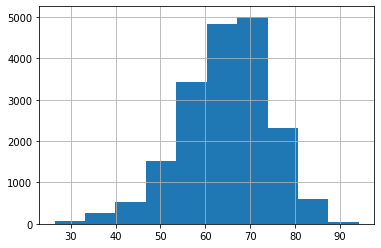

In [4]:
df_age = pd.read_csv(os.path.join(data_dir, 'Age_at_visit.csv'))

# Show histogram
df_age['AGE_AT_VISIT'].hist()

## MRI availability

In [5]:
# Read CSV
mri_df = pd.read_csv("./data/MRI_info.csv")

# Keep rows with visits we need
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}
mri_df.rename(columns={'Subject ID': 'PATNO', 'Visit code': 'EVENT_ID'}, inplace=True)
mri_df = mri_df[mri_df['EVENT_ID'].isin(visits)]
mri_df["PATNO"] = mri_df["PATNO"].astype(np.int64)
mri_df["Description"] = mri_df["Description"].astype(str)
mri_df

,PATNO,Sex,Visit,Age,Description,EVENT_ID
0,100001,M,Baseline,67.4,SAG 3D MPRAGE,BL
1,100017,F,Baseline,58.8,SAG 3D MPRAGE,BL
2,100017,F,Month 12,59.7,SAG 3D MPRAGE,V04
3,100738,F,Baseline,71.3,SAG FSPGR 3D VOLUMETRIC T1,BL
4,100878,M,Baseline,65.9,3D T1-weighted,BL
...,...,...,...,...,...,...
2088,85242,M,Month 24,66.1,MPRAGE_GRAPPA,V06
2089,85242,M,Month 24,66.1,MPRAGE_GRAPPA_ADNI,V06
2090,90456,M,Baseline,82.5,sag mprage,BL
2091,91097,M,Baseline,67.3,FSPGR 3D SAG,BL


## Merge H&Y, age and MRI information

In [6]:
keys = ['PATNO', 'EVENT_ID']

df_mri_age = df_age.merge(mri_df, how='right')
df_mri_age['AGE_AT_VISIT'].fillna(df_mri_age['Age'])

df = df_hy.merge(df_mri_age, how='right')
df

,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT,AGE_AT_VISIT,Sex,Visit,Age,Description
0,100001,BL,NaN,2,0.0,67.4,M,Baseline,67.4,SAG 3D MPRAGE
1,100017,BL,NaN,2,0.0,58.8,F,Baseline,58.8,SAG 3D MPRAGE
2,100017,V04,NaN,2,0.0,59.7,F,Month 12,59.7,SAG 3D MPRAGE
3,100738,BL,NaN,2,0.0,71.4,F,Baseline,71.3,SAG FSPGR 3D VOLUMETRIC T1
4,100878,BL,NaN,2,0.0,65.9,M,Baseline,65.9,3D T1-weighted
...,...,...,...,...,...,...,...,...,...,...
2061,85242,V06,NaN,0,0.0,65.7,M,Month 24,66.1,MPRAGE_GRAPPA
2062,85242,V06,NaN,0,0.0,65.7,M,Month 24,66.1,MPRAGE_GRAPPA_ADNI
2063,90456,BL,NaN,0,0.0,82.5,M,Baseline,82.5,sag mprage
2064,91097,BL,NaN,0,0.0,67.3,M,Baseline,67.3,FSPGR 3D SAG


In [7]:
df[df['NHY'].isna()]

,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT,AGE_AT_VISIT,Sex,Visit,Age,Description
23,101124,V04,NaN,NaN,NaN,74.4,M,Month 12,74.4,3D T1-weighted
25,101179,BL,NaN,NaN,NaN,44.0,F,Baseline,44.0,3D T1-weighted
48,102308,BL,NaN,NaN,NaN,60.5,M,Baseline,60.5,SAG 3D MPRAGE
49,102419,BL,NaN,NaN,NaN,48.3,M,Baseline,48.1,3D T1-weighted
57,108838,BL,NaN,NaN,NaN,NaN,M,Baseline,65.2,SAG 3D T1 FSPGR
...,...,...,...,...,...,...,...,...,...,...
1887,70463,BL,NaN,NaN,NaN,67.0,M,Baseline,67.0,MPRAGE_GRAPPA_ADNI
1888,70463,BL,NaN,NaN,NaN,67.0,M,Baseline,67.0,MPRAGE_GRAPPA
1961,73616,BL,NaN,NaN,NaN,57.4,M,Baseline,57.4,MPRAGE_GRAPPA_ADNI
1962,73616,BL,NaN,NaN,NaN,57.4,M,Baseline,57.4,MPRAGE_GRAPPA


In [8]:
df_hy[df_hy['PATNO']==70463]

,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT
16713,70463,SC,NaN,2,NaN
16717,70463,V06,OFF,2,1.0


## Format data by visit pairs

In [9]:

def next_visit(x):
    return visits[x]

In [10]:
visits_df = df

# Set id of second visit in pair
visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

# Retrieve H&Y score of next visit
visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

# Add patient sex to visit pairs
visits_df = visits_df.merge(demo, on=['PATNO'])

# Define visit as stable if NHY (first visit)
visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

In [11]:
visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  Sex  \
stable NHY_x                                                                
False  0        320         320          0         273           320  320   
       1        271         271         57         256           271  271   
       2        422         422        158         395           422  422   
       3         38          38         31          38            38   38   
       4          6           6          3           6             6    6   
       5          1           1          0           1             1    1   
       UR         1           1          1           1             1    1   
       NaN      267         267          0           0           251  267   
True   0        422         422          0         224           419  422   
       1         43          43         11          43            43   43   
       2        274         274        144         274           274  274   
       3          1           1          1           1             1    1   

              Visit  Age  Description  next_visit  EVENT_ID_y  PDSTATE_y  \
stable NHY_x                                                               
False  0        320  320          320         320          27          3   
       1        271  271          271         271         115         87   
       2        422  422          422         422          55         45   
       3         38   38           38          38           6          5   
       4          6    6            6           6           2          2   
       5          1    1            1           1           0          0   
       UR         1    1            1           1           0          0   
       NaN      267  267          267         267          86         79   
True   0        422  422          422         422         422          0   
       1         43   43           43          43          43         34   
       2        274  274          274         274         274        246   
       3          1    1            1           1           1          1   

              NHY_y  PDTRTMNT_y  SEX  
stable NHY_x                          
False  0         27          26  320  
       1        115         113  271  
       2         55          53  422  
       3          6           6   38  
       4          2           2    6  
       5          0           0    1  
       UR         0           0    1  
       NaN       86          86  267  
True   0        422         227  422  
       1         43          43   43  
       2        274         274  274  
       3          1           1    1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

In [12]:
df = visits_df
len(pd.unique(df[(df['stable'] == True) & (df['NHY_x'] == "1")]["PATNO"]))

34

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [13]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,Age,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,2066.000000,1512.000000,2047.000000,2066.000000,831.000000,2066.000000,2.047000e+03
mean,27452.385286,0.261905,63.141133,63.153727,0.604091,0.600194,7.636512e-17
std,31778.442485,0.439817,9.477297,9.487637,0.489339,0.489977,1.000000e+00
min,3000.000000,0.000000,30.600000,30.600000,0.000000,0.000000,-3.433588e+00
25%,3529.250000,0.000000,56.700000,56.700000,0.000000,0.000000,-6.796382e-01
50%,4022.000000,0.000000,64.000000,64.100000,1.000000,1.000000,9.062359e-02
75%,52353.000000,1.000000,70.200000,70.200000,1.000000,1.000000,7.448186e-01
max,146573.000000,1.000000,86.300000,86.300000,1.000000,1.000000,2.443615e+00


In [14]:
len(pd.unique(df[(df['stable'] == True) & (df['NHY_x'] == "1")]["PATNO"]))

34

## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [15]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = pd.unique(group1_df['PATNO'])
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)
    
    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 47 patients with H&Y=1
stable1, progr1 = match(34,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)

# Apply matching to get 25 patients with H&Y=2
stable2, progr2 = match(38,
                        df[(df['stable'] == True) & (df['NHY_x'] == "2")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "2")],
                        matched_vars)

/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
/tmp/ipykernel_693975/3590407843.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
/tmp/ipykernel_693975/3590407843.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

In [16]:
stable = stable1.append(stable2)
progr = progr1.append(progr2)

/tmp/ipykernel_693975/2664523030.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stable = stable1.append(stable2)
/tmp/ipykernel_693975/2664523030.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  progr = progr1.append(progr2)


## Sanity checks

In [17]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
print('All good!')

All good!


## Cohort summary

In [18]:
import os
print(f"\t\t\t\t\t| Stable set (n={len(stable)})\t| Progression set (n={len(progr)})" + os.linesep +
       f"Age (years) \t\t\t\t| {round(stable['AGE_AT_VISIT'].mean(),2)} \t\t| {round(progr['AGE_AT_VISIT'].mean(),2)}" + os.linesep + 
       f"Gender [male (n)] \t\t\t| {len(stable[stable['SEX']==1])} \t\t\t| {len(progr[progr['SEX']==1])}" + os.linesep +
       f"Hoehn & Yahr (n) \t Stage 1 \t| {len(stable[stable['NHY_x']=='1'])} \t\t\t| {len(progr[progr['NHY_x']=='1'])}" + os.linesep +
       f"\t\t\t Stage 2 \t| {len(stable[stable['NHY_x']=='2'])} \t\t\t| {len(progr[progr['NHY_x']=='2'])}" + os.linesep +
       f"\t\t\t Stage 3 \t| {len(stable[stable['NHY_x']=='3'])} \t\t\t| {len(progr[progr['NHY_x']=='3'])}"

)

					| Stable set (n=72)	| Progression set (n=72)
Age (years) 				| 60.0 		| 60.05
Gender [male (n)] 			| 43 			| 43
Hoehn & Yahr (n) 	 Stage 1 	| 34 			| 34
			 Stage 2 	| 38 			| 38
			 Stage 3 	| 0 			| 0


<AxesSubplot:>

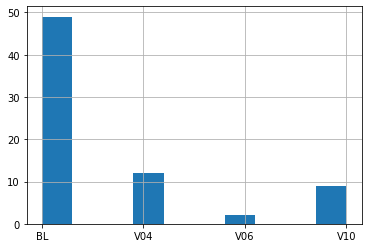

In [19]:
stable['EVENT_ID_x'].hist()

<AxesSubplot:>

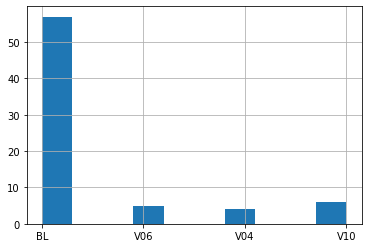

In [20]:
progr['EVENT_ID_x'].hist()

In [21]:
for visit in stable["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(stable[stable['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, stable[stable["EVENT_ID_x"] == visit]["PATNO"].values)))

FOR VISIT: BL - 49 patients
3421,3824,3961,3173,40692,52530,3661,3420,85242,51440,3960,3507,3430,4117,3431,50319,3834,3130,3429,3322,3838,3419,3327,73115,4096,3061,3446,3254,3650,3068,4071,3281,4107,4126,54265,40690,3415,40702,41420,3443,4108,41412,4101,4091,3088,3653,3763,3150,4030
FOR VISIT: V04 - 12 patients
3808,3328,3307,3815,3832,3819,3175,4037,3134,3181,3500,3822
FOR VISIT: V06 - 2 patients
3308,3321
FOR VISIT: V10 - 9 patients
4022,3309,3130,3383,40366,3120,3869,3127,3829


In [22]:
for visit in stable["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(stable[stable['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, stable[stable["EVENT_ID_x"] == visit]["PATNO"].values)))

FOR VISIT: BL - 49 patients
3421,3824,3961,3173,40692,52530,3661,3420,85242,51440,3960,3507,3430,4117,3431,50319,3834,3130,3429,3322,3838,3419,3327,73115,4096,3061,3446,3254,3650,3068,4071,3281,4107,4126,54265,40690,3415,40702,41420,3443,4108,41412,4101,4091,3088,3653,3763,3150,4030
FOR VISIT: V04 - 12 patients
3808,3328,3307,3815,3832,3819,3175,4037,3134,3181,3500,3822
FOR VISIT: V06 - 2 patients
3308,3321
FOR VISIT: V10 - 9 patients
4022,3309,3130,3383,40366,3120,3869,3127,3829


In [23]:
for visit in progr["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(progr[progr['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, progr[progr["EVENT_ID_x"] == visit]["PATNO"].values)) )

FOR VISIT: BL - 57 patients
3272,3593,3869,3825,4054,4056,115448,3174,3102,3802,3024,3532,75505,3170,3123,3664,3629,3079,3634,3407,124793,3269,137426,3309,3829,3185,3972,4036,3184,4051,3179,3006,3010,3381,3542,101482,3764,3374,3129,3800,116531,101047,3359,3762,3633,3530,5004,4033,5011,3818,3413,5008,3808,4070,3510,3256,3605
FOR VISIT: V06 - 5 patients
3836,52678,3166,56886,3580
FOR VISIT: V04 - 4 patients
3752,4082,3305,4136
FOR VISIT: V10 - 6 patients
4081,3132,3575,51632,41438,58783


In [24]:
mri_df[mri_df["PATNO"]==3702]

,PATNO,Sex,Visit,Age,Description,EVENT_ID


In [25]:
mri_df

,PATNO,Sex,Visit,Age,Description,EVENT_ID
0,100001,M,Baseline,67.4,SAG 3D MPRAGE,BL
1,100017,F,Baseline,58.8,SAG 3D MPRAGE,BL
2,100017,F,Month 12,59.7,SAG 3D MPRAGE,V04
3,100738,F,Baseline,71.3,SAG FSPGR 3D VOLUMETRIC T1,BL
4,100878,M,Baseline,65.9,3D T1-weighted,BL
...,...,...,...,...,...,...
2088,85242,M,Month 24,66.1,MPRAGE_GRAPPA,V06
2089,85242,M,Month 24,66.1,MPRAGE_GRAPPA_ADNI,V06
2090,90456,M,Baseline,82.5,sag mprage,BL
2091,91097,M,Baseline,67.3,FSPGR 3D SAG,BL


Visit 01 (Month 3)
Visit 02 (Month 6)
Visit 03 (Month 9)
Visit 04 (Month 12)
Visit 05 (Month 18)
Visit 06 (Month 24)
Visit 07 (Month 30)
Visit 08 (Month 36)
Visit 09 (Month 42)
Visit 10 (Month 48)
Visit 11 (Month 54)
Visit 12 (Month 60)
Visit 13 (Month 72)
Visit 14 (Month 84)
Visit 15 (Month 96)
Visit 16 (Month 108)
Visit 17 (Month 120)
Visit 18 (Month 132)
Visit 19 (Month 144)
Visit 20 (Month 156)

visits = {'BL': 'V08', 
          'V04': 'Month 12',
          'V06': 'Month 24',
          'V08': 'Month 36',
          'V10': 'Month 48'}